### 라이브러리 정의

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

from sklearn import set_config
set_config(display="text")
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### 데이터 불러오기

In [2]:
file_path_train = "./data/train.csv"
df_train = pd.read_csv(file_path_train)

df_train = df_train.drop("Id", axis=1)
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 이상치 시각화

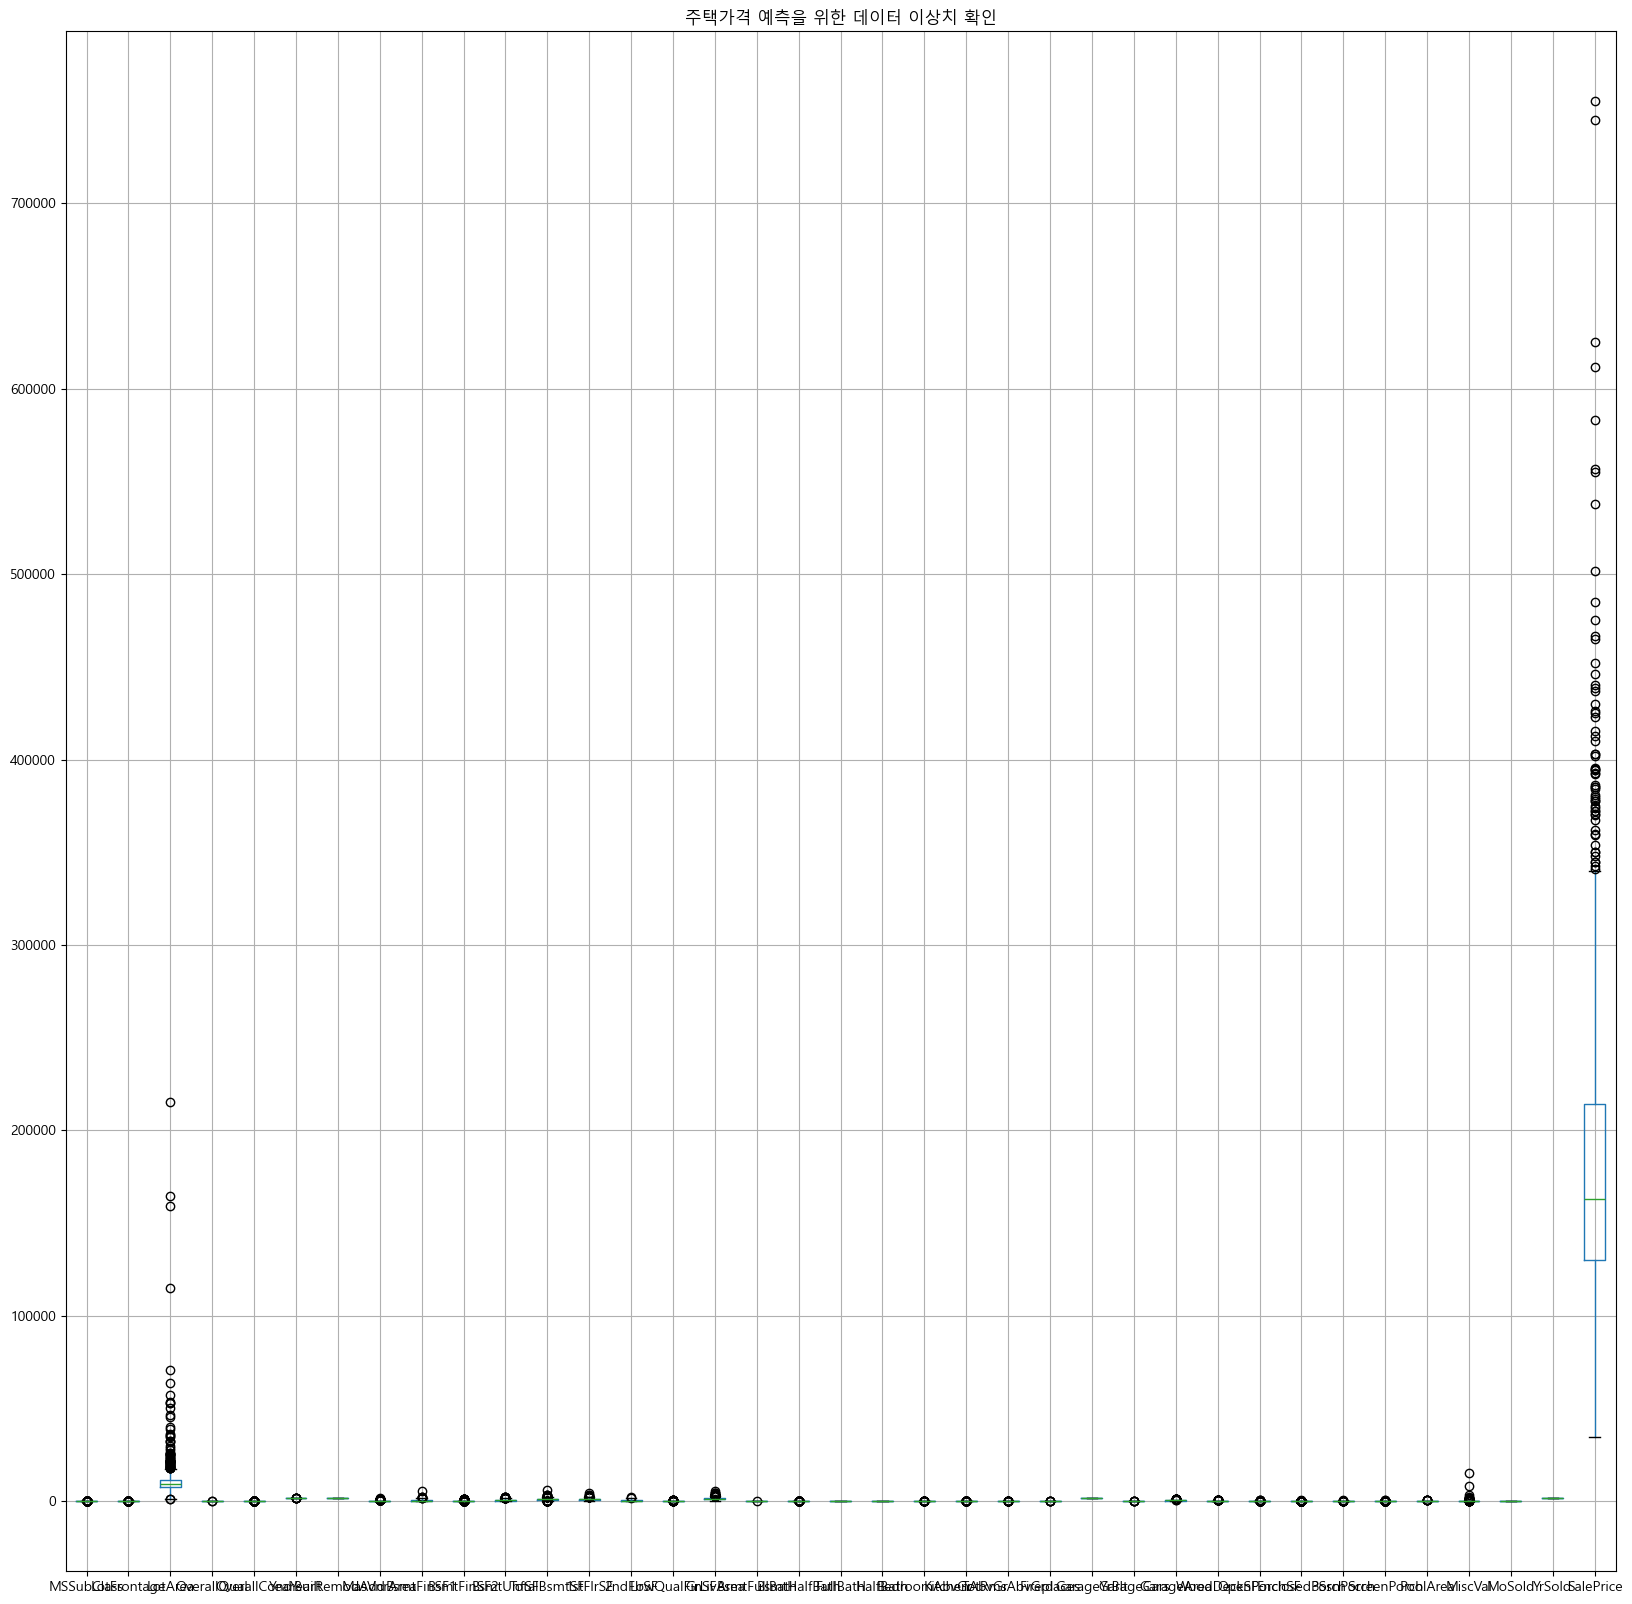

In [3]:
plt.figure(figsize=(20, 20))
plt.title("주택가격 예측을 위한 데이터 이상치 확인")
### 박스플롯 그리기
df_train.boxplot()
plt.show()

### 상관관계 매트릭스 시각화

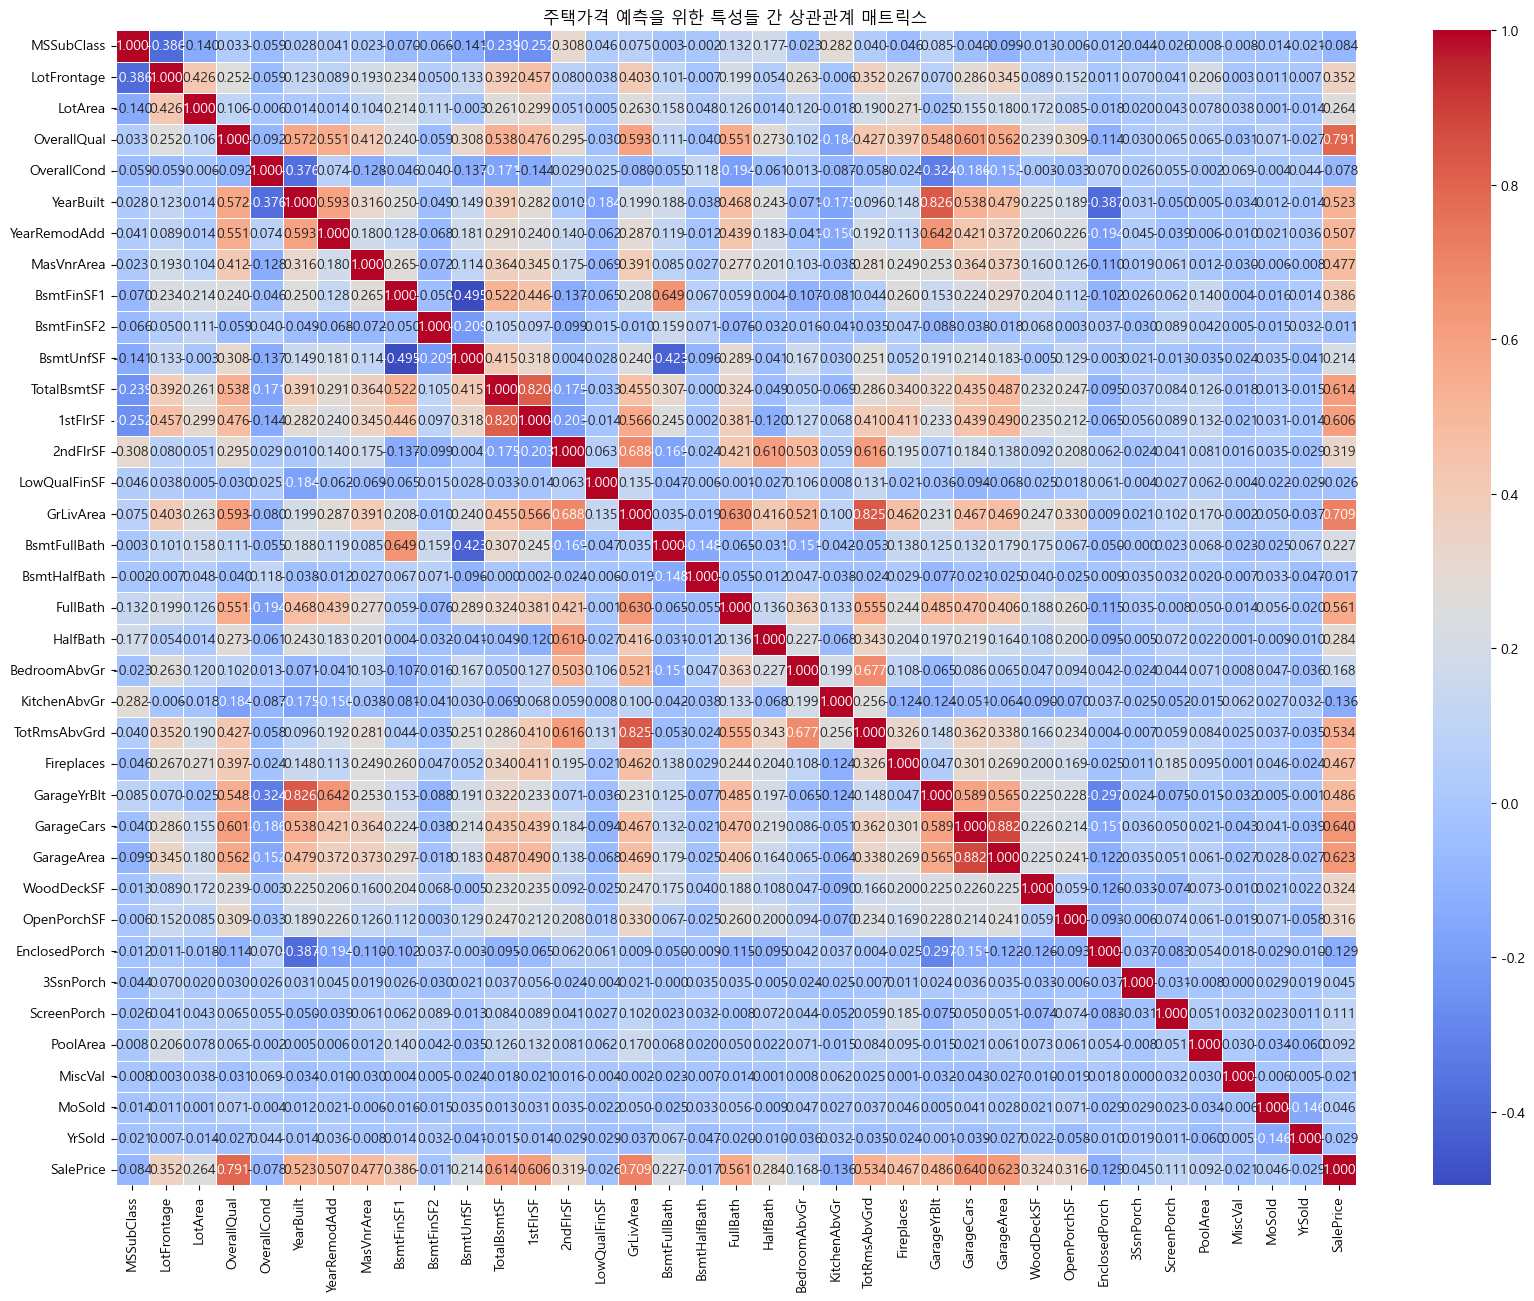

In [4]:
### 상관관계 표 : corr() 함수 사용(데이터프레임에 포함되어 있음)
df_numeric = df_train.select_dtypes(include=['int64', 'float64'])

# 상관관계 
cr = df_numeric.corr()

# 시각화
plt.figure(figsize=(20, 15))  # 그래프 크기 조정
plt.title("주택가격 예측을 위한 특성들 간 상관관계 매트릭스")
sns.heatmap(cr, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.show()

### 상관관계 우선순위 및 특성 중요도 도출

In [22]:
saleprice_corr = cr["SalePrice"].sort_values(ascending=False).abs()
saleprice_corr.head(6)

### "SalePrice"에 상관관계가 있는 순서대로 나열 
# OverallQual - 0.79 
# GrLivArea   - 0.70
# GarageCars  - 0.64
# GarageArea  - 0.62
# TotalBsmtSF - 0.61 로 가장 상관관계가 큰 5개 도출 가능
### 다만 음수 값이 보이는 값들이 보이며 해당 값들은 추후에 모델 생성 후 판단 예정
# 모델 생성 후 판단하는 이유 : 모델 및 정확성이 타당한지 먼저 보기 위해

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

In [19]:
x_spearmanr= df_numeric.drop(columns=["SalePrice"])
y_spearmanr = df_numeric["SalePrice"]
x_train, x_temp, y_train, y_temp = train_test_split(x_spearmanr, y_spearmanr, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Val MSE: {mse:.4f}")
print(f"Val R² Score: {r2:.4f}")

# 특성 중요도
feature_importance = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# 특성 중요도 출력
print(feature_importance)

Val MSE: 549322240.9364
Val R² Score: 0.9062
          Feature  Importance
3     OverallQual    0.563296
15      GrLivArea    0.124168
11    TotalBsmtSF    0.037689
13       2ndFlrSF    0.037295
8      BsmtFinSF1    0.034249
12       1stFlrSF    0.029626
2         LotArea    0.021040
26     GarageArea    0.018163
5       YearBuilt    0.016863
25     GarageCars    0.013691
1     LotFrontage    0.011904
6    YearRemodAdd    0.010757
24    GarageYrBlt    0.010258
22   TotRmsAbvGrd    0.008601
28    OpenPorchSF    0.007716
10      BsmtUnfSF    0.006263
18       FullBath    0.005913
27     WoodDeckSF    0.005889
4     OverallCond    0.005403
7      MasVnrArea    0.005292
34         MoSold    0.004582
0      MSSubClass    0.003608
31    ScreenPorch    0.003554
23     Fireplaces    0.003438
35         YrSold    0.002154
20   BedroomAbvGr    0.001988
19       HalfBath    0.001216
16   BsmtFullBath    0.001011
21   KitchenAbvGr    0.001003
9      BsmtFinSF2    0.000983
29  EnclosedPorch    0.00

### 피어슨, 스피어만 상관관계 도출 및 시각화

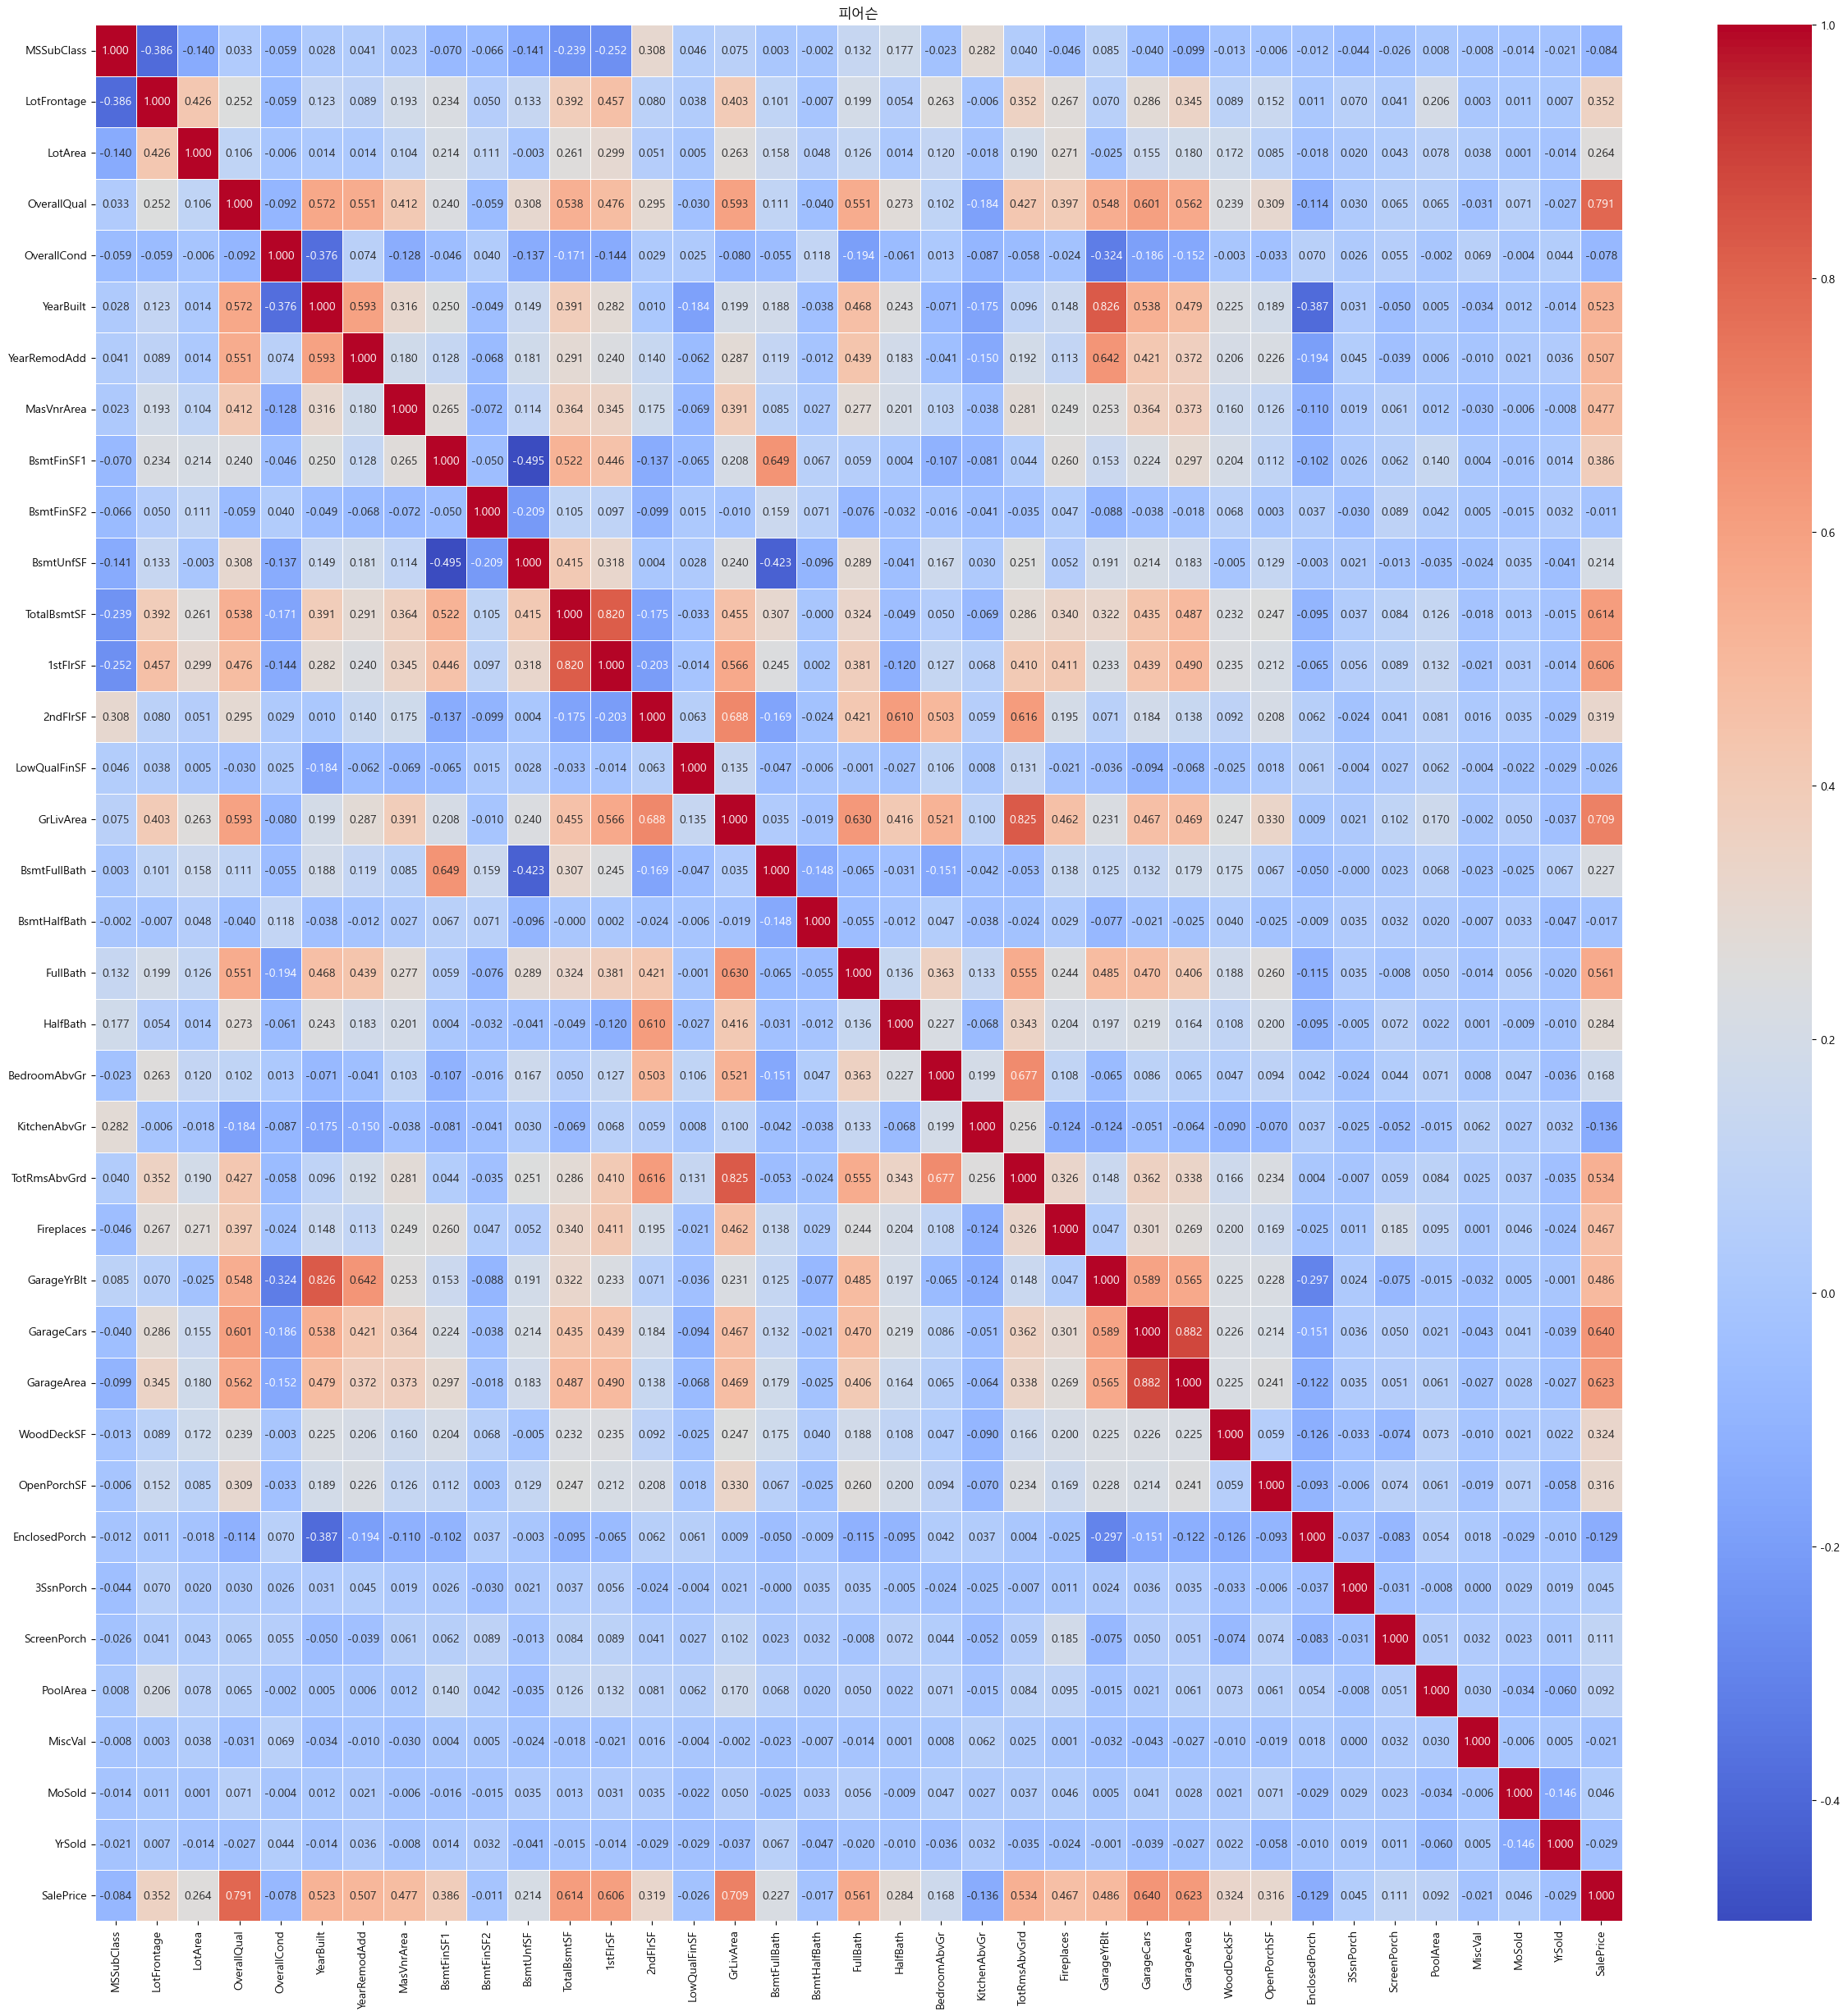

In [6]:
# 피어슨 상관계수
pearson_corr = df_numeric.corr(method="pearson")
pearson_corr

# 시각화 필요에 따라 출력 가능
plt.figure(figsize=(30, 30))
plt.title("피어슨")
sns.heatmap(pearson_corr, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.show()

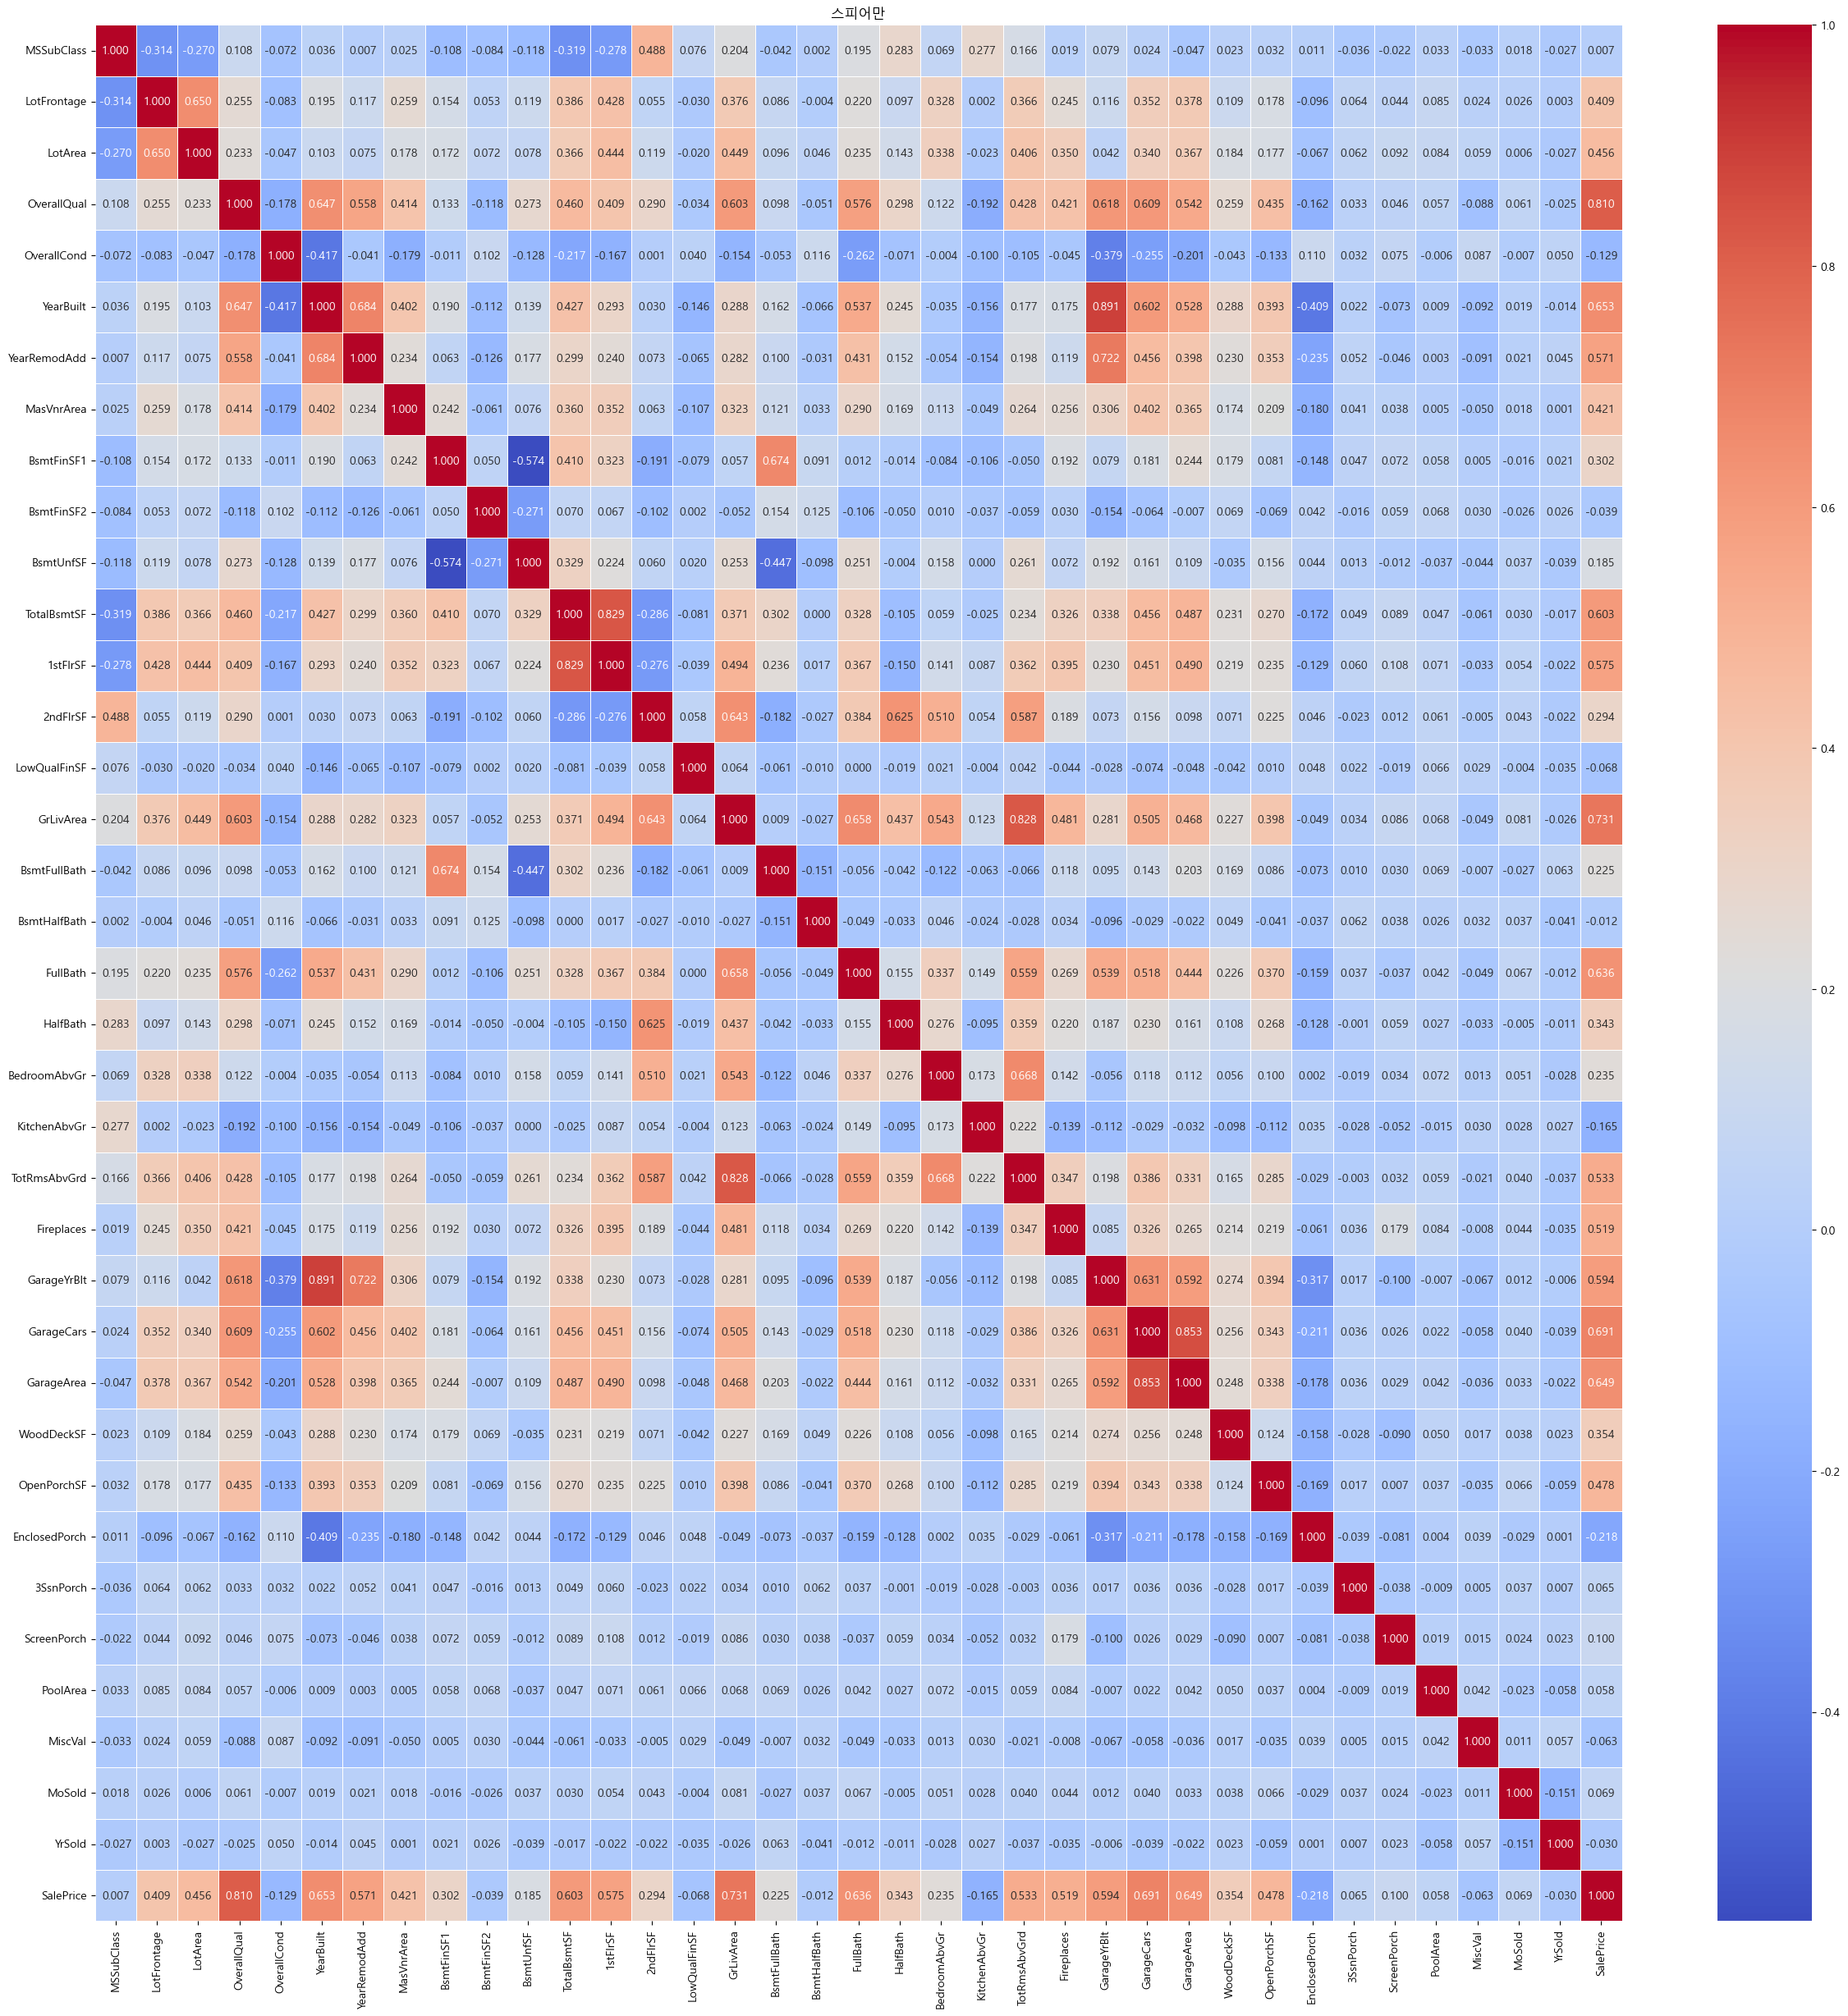

In [7]:
# 스피어만 상관계수 
spearman_corr = df_numeric.corr(method="spearman")
spearman_corr

# 시각화 위와 동일
plt.figure(figsize=(30, 30))
plt.title("스피어만")
sns.heatmap(spearman_corr, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)
plt.show()

### 결측치 확인 및 처리 과정

In [8]:
df_train.info()
# 위와 같이 info를 실행한 결과 결측치가 나타난 컬럼은 아래와 같음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [9]:
# print(df_train["Alley"].unique())        # ['nan', 'Grvl', 'Pave']
# print(df_train["LotFrontage"].unique())  # [85.  75.  nan  51.]
# print(df_train["MasVnrType"].unique())   # ['BrkFace' nan 'Stone' 'BrkCmn']
# print(df_train["MasVnrArea"].unique())   # [2.970e+02, nan, 6.040e+02, 2.540e+02]
# print(df_train["BsmtQual"].unique())     # ['Gd' 'TA' 'Ex' nan 'Fa']
# print(df_train["BsmtCond"].unique())     # ['TA' 'Gd' nan 'Fa' 'Po']
# print(df_train["BsmtExposure"].unique()) # ['No' 'Gd' 'Mn' 'Av' nan]
# print(df_train["BsmtFinType1"].unique()) # ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
# print(df_train["BsmtFinType2"].unique()) # ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
# print(df_train["Electrical"].unique())   # ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan] -> 결측치 값 하나이므로 "Mix" 로 대체
# print(df_train["FireplaceQu"].unique())  # [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
# print(df_train["GarageType"].unique())   # ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
# print(df_train["GarageYrBlt"].unique())  # [2003. 1976. 2001. ... nan  ... 1929. 1933.]
# print(df_train["GarageFinish"].unique()) # ['RFn' 'Unf' 'Fin' nan]
# print(df_train["GarageQual"].unique())   # ['TA', 'Fa', 'Gd', 'nan', 'Ex', 'Po']
# print(df_train["GarageCond"].unique())   # ['TA', 'Fa', 'Gd', 'nan', 'Ex', 'Po']
# print(df_train["PoolQC"].unique())       # [nan 'Ex' 'Fa' 'Gd']
# print(df_train["Fence"].unique())        # [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
# print(df_train["MiscFeature"].unique())  # [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [10]:
df_train["Alley"] = df_train["Alley"].fillna(0)
df_train['Alley'] = df_train['Alley'].replace({ 'Grvl' : 1, 'Pave' : 2})
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(0)
num = df_train.loc[df_train["LotFrontage"] != 0, "LotFrontage"]
df_train.loc[df_train["LotFrontage"] == 0, "LotFrontage"] = int(num.mean())


df_train['MasVnrArea']   = df_train['MasVnrArea'].fillna(0)
df_train['MasVnrType']   = df_train['MasVnrType'].fillna(0)
df_train['BsmtQual']     = df_train['BsmtQual'].fillna(0)
df_train['BsmtCond']     = df_train['BsmtCond'].fillna(0)
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna(0)
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna(0)
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna(0)
df_train["ExterQual"] = df_train['ExterQual'].replace({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype(int)
df_train['ExterCond'] = df_train['ExterCond'].replace({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype(int)
df_train["BsmtQual"] = df_train['BsmtQual'].replace({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype(int)
df_train["BsmtCond"] = df_train['BsmtCond'].replace({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype(int)
df_train["BsmtExposure"] = df_train['BsmtExposure'].replace({'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype(int)
df_train["BsmtFinType1"] = df_train['BsmtFinType1'].replace({'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}).astype(int)
df_train["BsmtFinType2"] = df_train['BsmtFinType2'].replace({'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}).astype(int)
df_train["HeatingQC"] = df_train['HeatingQC'].replace({'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype(int)


df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna(0)
df_train['FireplaceQu'] = df_train['FireplaceQu'].replace({'Po' : 1,'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}).astype(int) # 완료
df_train["GarageType"] = df_train["GarageType"].fillna(0)
df_train['GarageType'] = df_train['GarageType'].replace({'na': 0, '2Types': 1, 'Attchd': 2,'Basment' : 3,'BuiltIn': 4,'CarPort': 5,'Detchd': 6}).astype(int)
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(0)
df_train["GarageFinish"] = df_train["GarageFinish"].fillna(0)
df_train['GarageFinish'] = df_train['GarageFinish'].replace({'na' : 0, "Fin" : 1, "RFn" : 2, "Unf" : 3}).astype(int)


df_train['GarageQual'] = df_train['GarageQual'].fillna(0)
df_train['GarageCond'] = df_train['GarageCond'].fillna(0)
df_train['PoolQC'] = df_train['PoolQC'].fillna(0)
df_train['Fence'] = df_train['Fence'].fillna(0)
df_train['MiscFeature'] = df_train['MiscFeature'].fillna(0)

df_train['GarageQual'] = df_train['GarageQual'].replace({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}).astype(int)
df_train['GarageCond'] = df_train['GarageCond'].replace({"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}).astype(int)
df_train['PoolQC'] = df_train['PoolQC'].replace({"Fa": 1, "Gd": 3, "Ex": 4}).astype(int)
df_train['Fence'] = df_train['Fence'].replace({'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype(int)
df_train['MiscFeature'] = df_train['MiscFeature'].replace({'Shed': 1, 'Gar2': 1, 'Othr': 1, 'TenC': 1}).astype(int)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23436\2883147912.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['Alley'] = df_train['Alley'].replace({ 'Grvl' : 1, 'Pave' : 2})
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23436\2883147912.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["ExterQual"] = df_train['ExterQual'].replace({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}).astype(int)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_23436\2883147912.py:16: FutureWarning: Downcasting beha

In [ ]:
df_train.info()
# info 출력으로 결측치가 없는 것을 확인함


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   int64  
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

### 범주형데이터 처리

In [12]:
string_cols = df_train.select_dtypes(include=['object']).columns
# 모든 범주형 컬럼을 문자열(str)로 변환
df_train[string_cols] = df_train[string_cols].astype(str)

# OrdinalEncoder 생성
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Ordinal Encoding 적용
df_encoded = df_train.copy()
df_encoded[string_cols] = encoder.fit_transform(df_train[string_cols])

# 실수형 데이터를 정수형으로 변환
df_encoded = df_encoded.astype(int)

# 변환 결과 확인
print("변환된 데이터 형태:", df_encoded.shape)

# 최종 데이터프레임
df_encoded.info()
df_encoded["FireplaceQu"].unique()

변환된 데이터 형태: (1460, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   MSSubClass     1460 non-null   int32
 1   MSZoning       1460 non-null   int32
 2   LotFrontage    1460 non-null   int32
 3   LotArea        1460 non-null   int32
 4   Street         1460 non-null   int32
 5   Alley          1460 non-null   int32
 6   LotShape       1460 non-null   int32
 7   LandContour    1460 non-null   int32
 8   Utilities      1460 non-null   int32
 9   LotConfig      1460 non-null   int32
 10  LandSlope      1460 non-null   int32
 11  Neighborhood   1460 non-null   int32
 12  Condition1     1460 non-null   int32
 13  Condition2     1460 non-null   int32
 14  BldgType       1460 non-null   int32
 15  HouseStyle     1460 non-null   int32
 16  OverallQual    1460 non-null   int32
 17  OverallCond    1460 non-null   int32
 18  YearBuilt      1460 non-n

array([0, 3, 4, 2, 5, 1])

In [13]:
encoder.categories_

[array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object),
 array(['Grvl', 'Pave'], dtype=object),
 array(['IR1', 'IR2', 'IR3', 'Reg'], dtype=object),
 array(['Bnk', 'HLS', 'Low', 'Lvl'], dtype=object),
 array(['AllPub', 'NoSeWa'], dtype=object),
 array(['Corner', 'CulDSac', 'FR2', 'FR3', 'Inside'], dtype=object),
 array(['Gtl', 'Mod', 'Sev'], dtype=object),
 array(['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr',
        'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel',
        'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown',
        'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
        'Veenker'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe',
        'RRNn'], dtype=object),
 array(['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn'],
       dtype=object),
 array(['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'], dtype=object),
 array(['1.5Fin', '1.5Unf', '1Story', '2.

In [14]:
save_path = "./data/data_preprocessing.csv"
df_encoded.to_csv(save_path, index=False)